# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from joblib import dump, load

from sklearn.linear_model import LogisticRegression
# importing Cross validation libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score,recall_score,precision_score
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(r'/home/pranay/ML datasource/amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B005ZBZLT4                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ESG  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B005ZBZLT4        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ESG           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBEV0   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B001ATMQK2  undertheshrine "undertheshrine"  1296691200   

       Score                                               Text  COUNT(*)  
80638      5  I bought this 6 pack because for the price tha...         5

In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
#filtered out whole reviews

from bs4 import BeautifulSoup
# Combining all the above stundents 
from tqdm import tqdm
# tqdm is for printing the status bar
word_counter = []
def filterised_text(text):
    preprocessed_text = []
    for sentance in tqdm(text):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        count = len(sentance.split())
        word_counter.append(count)
        preprocessed_text.append(sentance.strip())
    return preprocessed_text

In [23]:
preprocessed_reviews = filterised_text(final['Text'].values)
final['preprocessed_reviews']  = preprocessed_reviews
preprocessed_reviews[1822]

100%|██████████| 87773/87773 [00:28<00:00, 3129.46it/s]


'taste great using air popper not great little seeds fall popping'

In [24]:
final['numbers_of_words']  = word_counter
word_counter[1822]

11

## [3.2] Preprocessing Review Summary

In [25]:
preprocessed_summary = filterised_text(final['Summary'].values)
final['preprocessed_summary']  = preprocessed_summary
preprocessed_summary[1822]

100%|██████████| 87773/87773 [00:17<00:00, 5134.61it/s]


'pop corn'

In [26]:
avg_w2v_trained_model_100000 = '/home/pranay/ML trained models/W2V/avg_w2v_trained_model_100000'
avg_w2v_test_model_100000 = '/home/pranay/ML trained models/W2V/avg_w2v_test_model_100000'

w2v_tf_idf_trained_model_100000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_trained_model_100000'
w2v_tf_idf_test_model_100000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_test_model_100000'

In [27]:
# Common Methods

depth_ = [2,5,7,10,20,30,50,100,200,300]
depth_ = np.asarray(depth_)

min_samples_ = np.arange(2,20,2)

def finding_best_depth_val(X_tr,y_tr,which_method,hyper_param):

    # instantiate a Decision Tree Classifier
    clf = DecisionTreeClassifier(class_weight='balanced', random_state=1)
    
    if hyper_param == 'depth':
        param_grid=dict(max_depth=depth_)
    elif hyper_param == 'min_samples':
        param_grid=dict(min_samples_split=min_samples_)
    else:
        param_grid=dict(max_depth=depth_,min_samples_split = min_samples_)
    
    #For time based splitting
    tscv = TimeSeriesSplit(n_splits=10)
    
    if which_method == 'gridsearch':
    
        # instantiate the grid for training data
        trained = GridSearchCV(clf, param_grid, cv=tscv, scoring='roc_auc',n_jobs =-1,verbose=10 )
    else:
        # instantiate the grid for training data
        trained = RandomizedSearchCV(clf, param_grid, cv=tscv, scoring='roc_auc',n_jobs =-1, n_iter = 15,verbose=10)
        
    # fit with traing data
    trained.fit(X_tr, y_tr)
    
    return trained


# plot a graph which show difference between validation error and training error
def plotAccuracyGraph(training_grid,which_hyperparam):
    
    if which_hyperparam == 'depth':
        hyper_range = [i for i in depth_]
    elif which_hyperparam == 'min_samples':
        hyper_range = [i for i in min_samples_]
        
    error_training = [(i)*100 for i in training_grid.cv_results_['mean_train_score']]
    error_test = [(i)*100 for i in training_grid.cv_results_['mean_test_score']]
    plt.plot(hyper_range, error_training,'r',label='train_error')
    plt.plot(hyper_range, error_test,'b',label='validation_error')
    plt.title('Accuracy Plt')
    plt.xlabel(which_hyperparam)
    plt.ylabel('Accuracy')
    plt.grid('on')
    plt.legend()
    plt.show()
    
# https://www.geeksforgeeks.org/confusion-matrix-machine-learning/    
def plotConfusionMatrix(y_test,pred):
    # calculate confusion matrix
    cm =  confusion_matrix(y_test,pred)
    class_label = ['negative', 'positive']
    df_conf_matrix = pd.DataFrame(cm, index=class_label, columns=class_label)
    # heatmap --> Plot rectangular data as a color-encoded matrix. 
    sns.heatmap(df_conf_matrix, annot=True, fmt='d')
    # give title to graph
    plt.title("Confusion Matrix")
    # mention axis label
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    # show the plot
    plt.show()
    
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

# plot AUC curve
def plotAUC_ROC(nb_optimal,X_train, y_train, X_test, y_test):
    # predict probabilities
    test_probs = nb_optimal.predict_proba(X_test)
    train_probs = nb_optimal.predict_proba(X_train)
    
    # keep probabilities for the positive outcome only
    test_probs = test_probs[:, 1]
    train_probs = train_probs[:, 1]
    
    # calculate AUC
    test_auc = roc_auc_score(y_test, test_probs)
    train_auc = roc_auc_score(y_train, train_probs)
    
    # calculate roc curve
    train_fpr, train_tpr, thresholds = roc_curve(y_train, train_probs)
    test_fpr, test_tpr, thresholds2 = roc_curve(y_test, test_probs)
    
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    
    # plot the roc curve for the model
    pyplot.plot(train_fpr, train_tpr, 'r',marker='.', label="train AUC ="+str(train_auc))
    pyplot.plot(test_fpr, test_tpr, 'b',marker='.',label="test AUC ="+str(test_auc))
    
    pyplot.legend()
    pyplot.xlabel("K: hyperparameter")
    pyplot.ylabel("AUC")
    pyplot.title("ERROR PLOTS")
    # show the plot
    pyplot.show()
    
    return train_auc, test_auc

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    

### Splitting data

__We have considered 100 k points__

In [28]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(61441,) (26332,) (61441,) (26332,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [55]:
##BoW

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10) #in scikit-learn

# train data
X_train_bow = count_vect.fit_transform(X_train)

# test data
x_test_bow = count_vect.transform(x_test)


print('X_train_bow',X_train_bow.shape)
print('==='*10)
print('x_test_bow',x_test_bow.shape)

X_train_bow (61441, 36487)
x_test_bow (26332, 36487)


### Hyper param Tuning using GridSearch

##### finding 'max depth' which have maximum AUC Score

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  9.2min finished


=======Training========
0.7708485855182997
{'max_depth': 10}
DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')


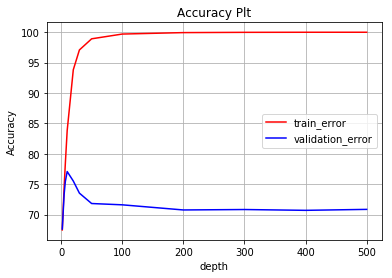

In [37]:
bow_train = finding_best_depth_val(X_train_bow,y_train,'gridsearch','depth')

# view the complete results (list of named tuples)
print("=======Training========")
print (bow_train.best_score_)
print (bow_train.best_params_)
print (bow_train.best_estimator_)

plotAccuracyGraph(bow_train, 'depth')
best_depth_size = bow_train.best_params_.get("max_depth", "")

##### finding 'min sample' which have maximum AUC Score

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 11.4min finished


=======Training========
0.7244373275275562
{'min_samples_split': 18}
DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=18,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')


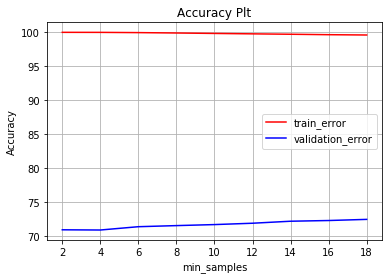

In [38]:
bow_train = finding_best_depth_val(X_train_bow,y_train,'gridsearch','min_samples')

# view the complete results (list of named tuples)
print("=======Training========")
print (bow_train.best_score_)
print (bow_train.best_params_)
print (bow_train.best_estimator_)

plotAccuracyGraph(bow_train,'min_samples')
best_min_samples_split = bow_train.best_params_.get("min_samples_split","")

## Decision Tree BoW


Max Depth : 5

Min Sample Split : 5

Confusion Matrix for Train data


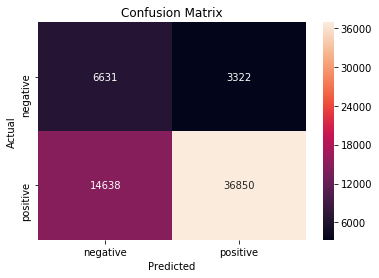


Confusion Matrix for Test data


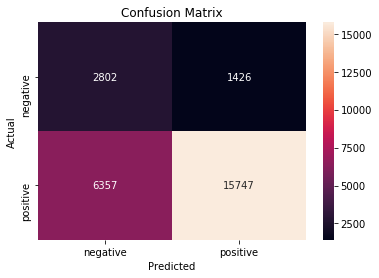

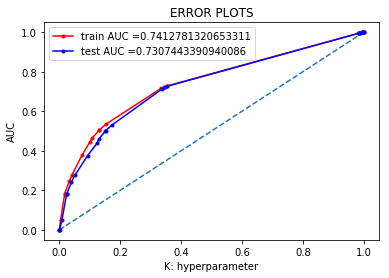


AUC (Train): 0.7412781320653311

AUC (Test): 0.7307443390940086

F1 SCORE (Train) : 0.804058476980144

F1 SCORE (Test) : 0.8018433179723502

RECALL (Train): 0.7157007458048478

RECALL (Test): 0.7124049945711184

PRECISION  (Train) : 0.9173055859802848

PRECISION  (Test) : 0.916962673964945


In [56]:
optimal_model = DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

# fitting the model
optimal_model.fit(X_train_bow, y_train)

# predict the response
test_pred = optimal_model.predict(x_test_bow)
train_pred = optimal_model.predict(X_train_bow)

print('\n'+color.RED+'Max Depth : '+color.END+color.BOLD+str(5)+color.END)
print('\n'+color.RED+'Min Sample Split : '+color.END+color.BOLD+str(5)+color.END)


# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_model,X_train_bow, y_train,x_test_bow, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

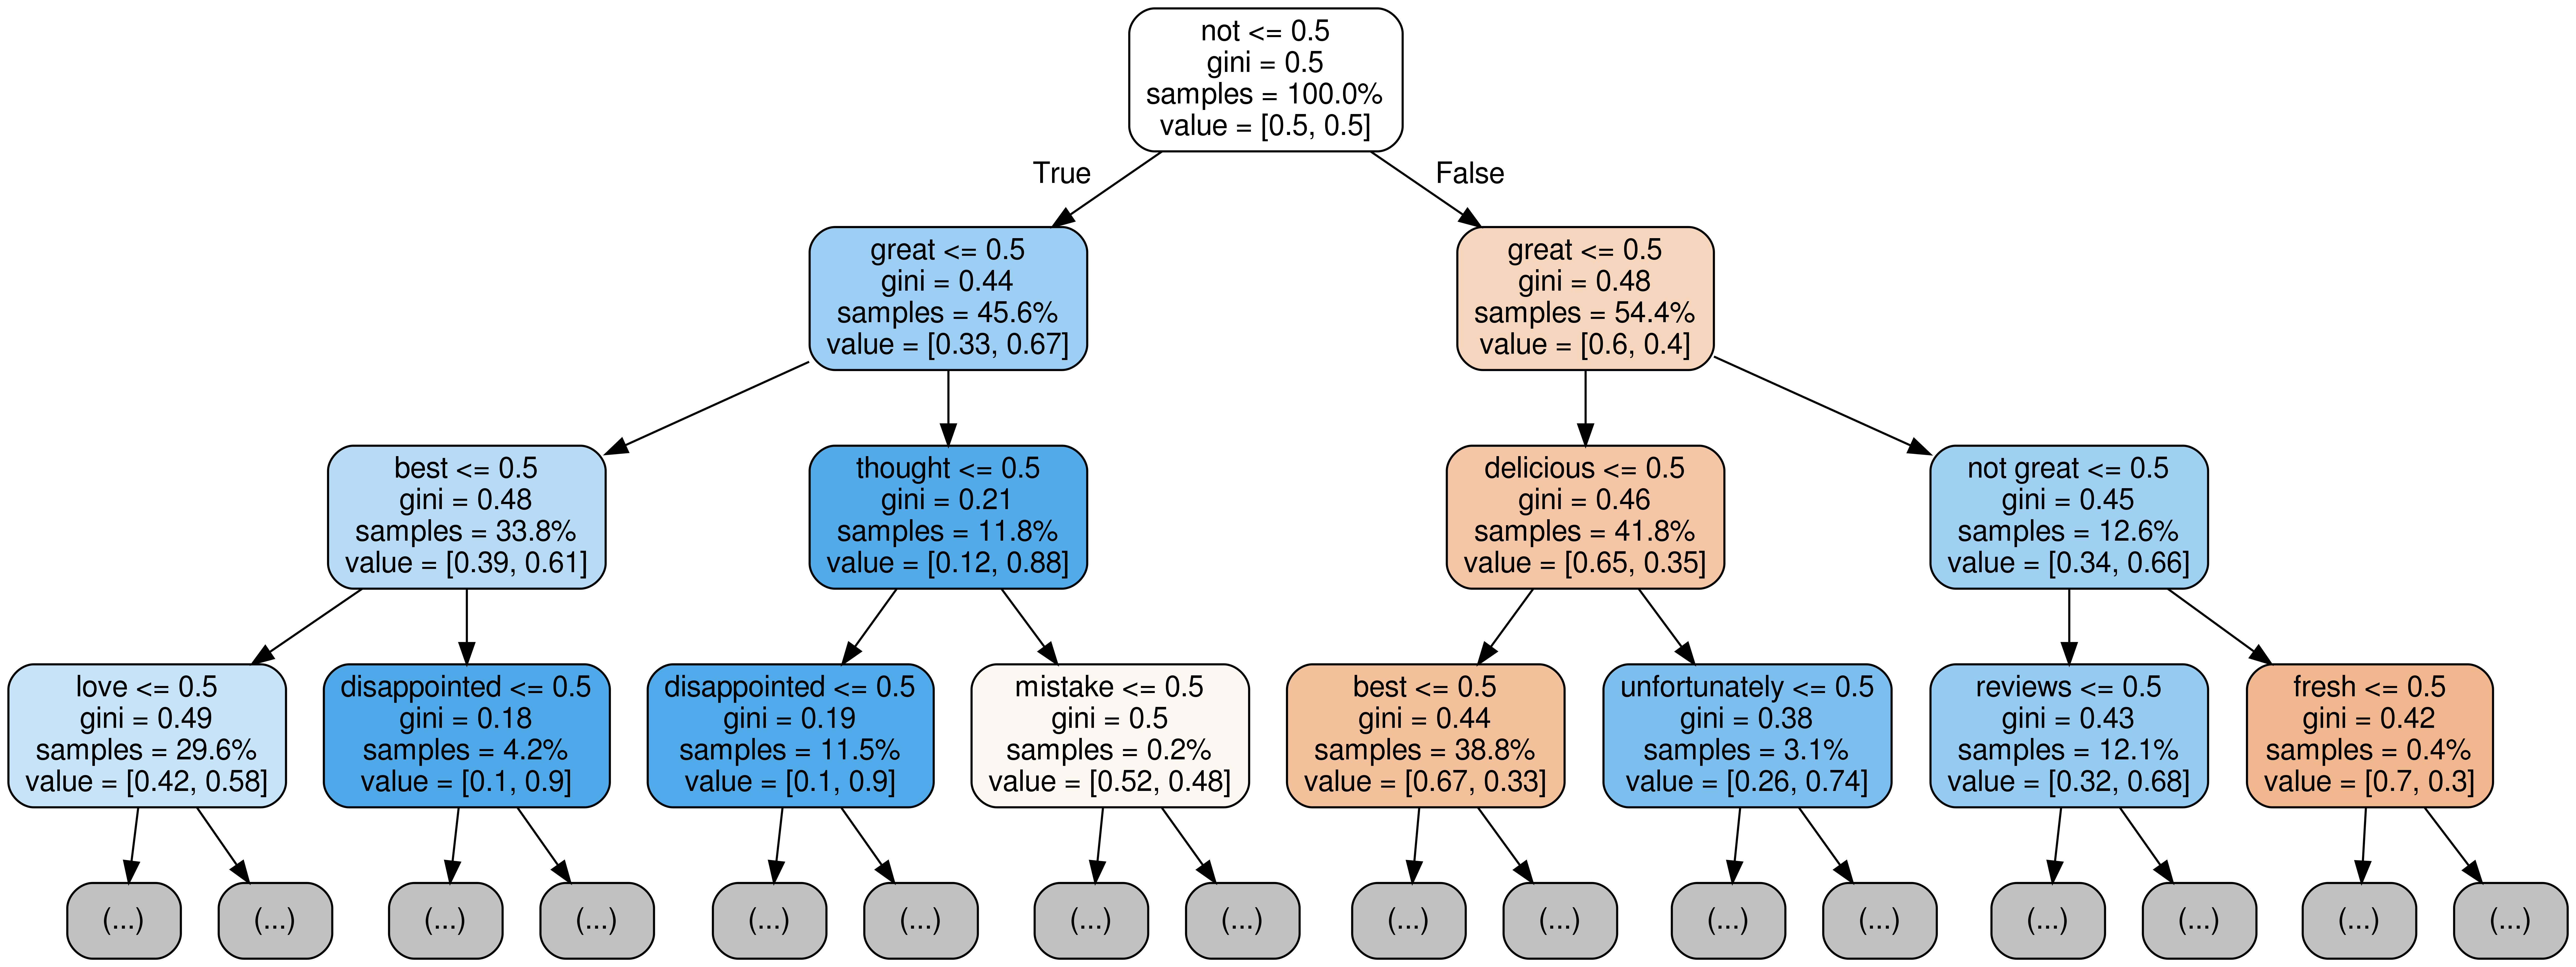

In [32]:
from sklearn.tree import export_graphviz
features_list = count_vect.get_feature_names()
# Export as dot file
export_graphviz(optimal_model, 
                out_file='bow.dot', 
                max_depth=3,
                rounded = True, 
                proportion = True, 
                precision = 2, 
                filled = True,
                special_characters=False,
                feature_names=features_list
                )

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'bow.dot', '-o', 'bow.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'bow.png')

### Top 20 features

In [33]:
topn_class = sorted(zip(optimal_model.feature_importances_, count_vect.get_feature_names()),reverse=True)[:20]
for feature, value in topn_class:
    print(feature, value)

0.3317625571204647 not
0.2574948123509848 great
0.10633094386711334 best
0.07543760600664272 delicious
0.0465824453843888 perfect
0.040411452573278016 love
0.0358339931916524 good
0.018056431590114552 product
0.01650249441841873 not great
0.01596521459491001 reviews
0.01261285455945545 disappointed
0.008356208013965458 thought
0.008172528930207059 bad
0.0056187951865294995 awful
0.004637081694385599 unfortunately
0.004476268039543524 not worth
0.0028953250337050143 stale
0.001826413572287339 highly
0.0015643724288715098 fresh
0.0015391598766586185 long


### Feature Engineering

Till now we only consider Text review as feature, we are adding some extra feature like __review summary__ and __number of words__ in review and test our model improves efficiency or not.

We have considered on 50000 points due to memory issue.

(35000, 13) (15000, 13) (35000,) (15000,)

Confusion Matrix for Train data


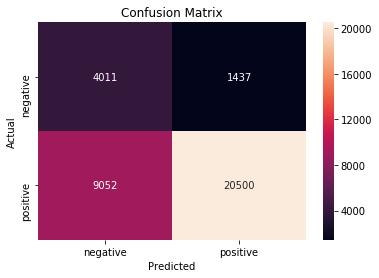


Confusion Matrix for Test data


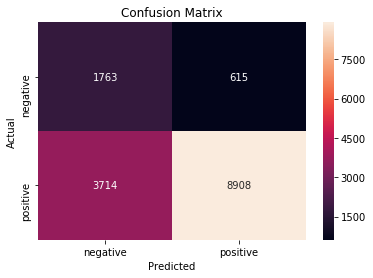

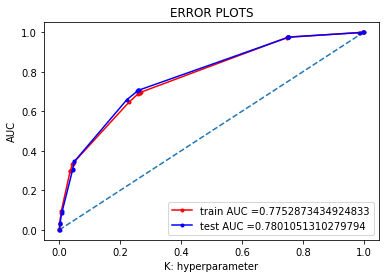


AUC (Train): 0.7752873434924833

AUC (Test): 0.7801051310279794

F1 SCORE (Train) : 0.7962865854842782

F1 SCORE (Test) : 0.8045156920298036

RECALL (Train): 0.6936924742826205

RECALL (Test): 0.7057518618285533

PRECISION  (Train) : 0.9344942334868032

PRECISION  (Test) : 0.935419510658406


In [34]:
# https://sondosatwi.wordpress.com/2017/08/01/using-text-data-and-dataframemapper-in-python/

X = final[:50000]
y = final['Score'][:50000]

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

mapper = DataFrameMapper([
     ('preprocessed_reviews', CountVectorizer(ngram_range=(1,3), min_df=10)),
     ('preprocessed_summary', CountVectorizer(ngram_range=(1,3), min_df=10)),
     ('numbers_of_words', None),
 ])

train_features = mapper.fit_transform(X_train)
test_features = mapper.transform(x_test)

optimal_model = DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

# fitting the model
optimal_model.fit(train_features,y_train)

# predict the response
test_pred = optimal_model.predict(test_features)
train_pred = optimal_model.predict(train_features)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_model,train_features, y_train,test_features, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

## [4.3] TF-IDF

In [29]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

tf_idf_vect = TfidfVectorizer(ngram_range=(1,3), min_df=10) #in scikit-learn

# train data
X_train_tfidf = tf_idf_vect.fit_transform(X_train)

# test data
x_test_tfidf = tf_idf_vect.transform(x_test)

print('X_train_tfidf', X_train_tfidf.shape)
print('==='*10)
print('x_test_tfidf', x_test_tfidf.shape)

(61441,) (26332,) (61441,) (26332,)
X_train_tfidf (61441, 40217)
x_test_tfidf (26332, 40217)


### Hyper param Tuning using GridSearch finding depth

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 12.7min finished


=======Training========
0.767972520880331
{'max_depth': 10}
DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')


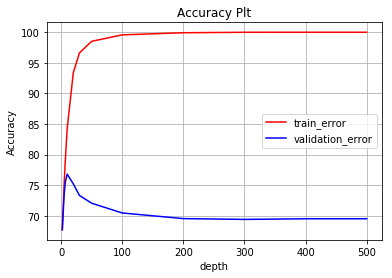

In [44]:
tfidf_train = finding_best_depth_val(X_train_tfidf,y_train,'gridsearch','depth')

# view the complete results (list of named tuples)
print("=======Training========")
print (tfidf_train.best_score_)
print (tfidf_train.best_params_)
print (tfidf_train.best_estimator_)

plotAccuracyGraph(tfidf_train,'depth')
best_depth_size = tfidf_train.best_params_.get("max_depth", "")

##### finding 'min sample' which have maximum AUC Score

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 15.3min finished


=======Training========
0.7104610200198547
{'min_samples_split': 18}
DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=18,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')


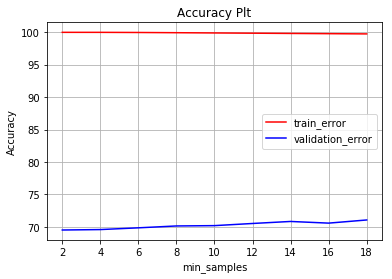

In [45]:
tfidf_train = finding_best_depth_val(X_train_tfidf,y_train,'gridsearch','min_samples')

# view the complete results (list of named tuples)
print("=======Training========")
print (tfidf_train.best_score_)
print (tfidf_train.best_params_)
print (tfidf_train.best_estimator_)

plotAccuracyGraph(tfidf_train,'min_samples')
best_min_samples_split = tfidf_train.best_params_.get("min_samples_split","")


## Apply Decision Tree on TFIDF


Max Depth : 5

Min Sample Split : 7

Confusion Matrix for Train data


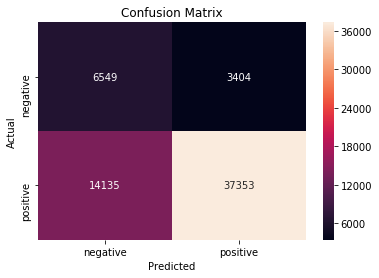


Confusion Matrix for Test data


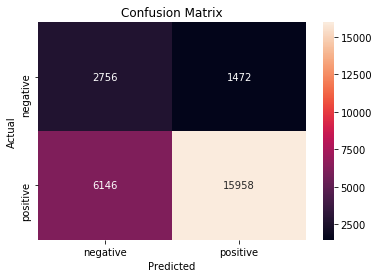

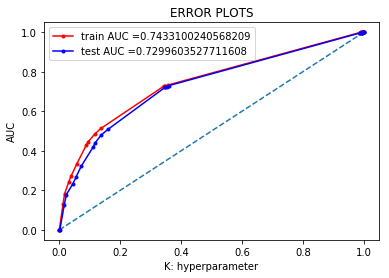


AUC (Train): 0.7433100240568209

AUC (Test): 0.7299603527711608

F1 SCORE (Train) : 0.8098650333351401

F1 SCORE (Test) : 0.807305104467041

RECALL (Train): 0.7254700124300808

RECALL (Test): 0.7219507781397032

PRECISION  (Train) : 0.9164806045587262

PRECISION  (Test) : 0.9155479059093516


In [30]:
optimal_model = DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

# fitting the model
optimal_model.fit(X_train_tfidf, y_train)

# predict the response
test_pred = optimal_model.predict(x_test_tfidf)
train_pred = optimal_model.predict(X_train_tfidf)

print('\n'+color.RED+'Max Depth : '+color.END+color.BOLD+str(5)+color.END)
print('\n'+color.RED+'Min Sample Split : '+color.END+color.BOLD+str(7)+color.END)


# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_model,X_train_tfidf, y_train,x_test_tfidf, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

### Top 20 Features

In [31]:
topn_class = sorted(zip(optimal_model.feature_importances_, tf_idf_vect.get_feature_names()),reverse=True)[:20]
for feature, value in topn_class:
    print(feature, value)

0.3353011045425829 not
0.25471227997931056 great
0.10475206357694236 best
0.07271020885279046 delicious
0.047811191391849445 perfect
0.04331207739065937 good
0.04264971299849017 love
0.01723605263516273 not great
0.016152154783745012 reviews
0.012912658685004887 disappointed
0.010947022565123471 unfortunately
0.009846582762796683 earth best
0.009189726306504727 would
0.00789286872597388 awful
0.004548812881625928 not worth
0.004532597841123398 return
0.0018397844940934722 bit
0.0018091863423845482 full
0.0007851299895464015 got
0.00036564278016099907 bag


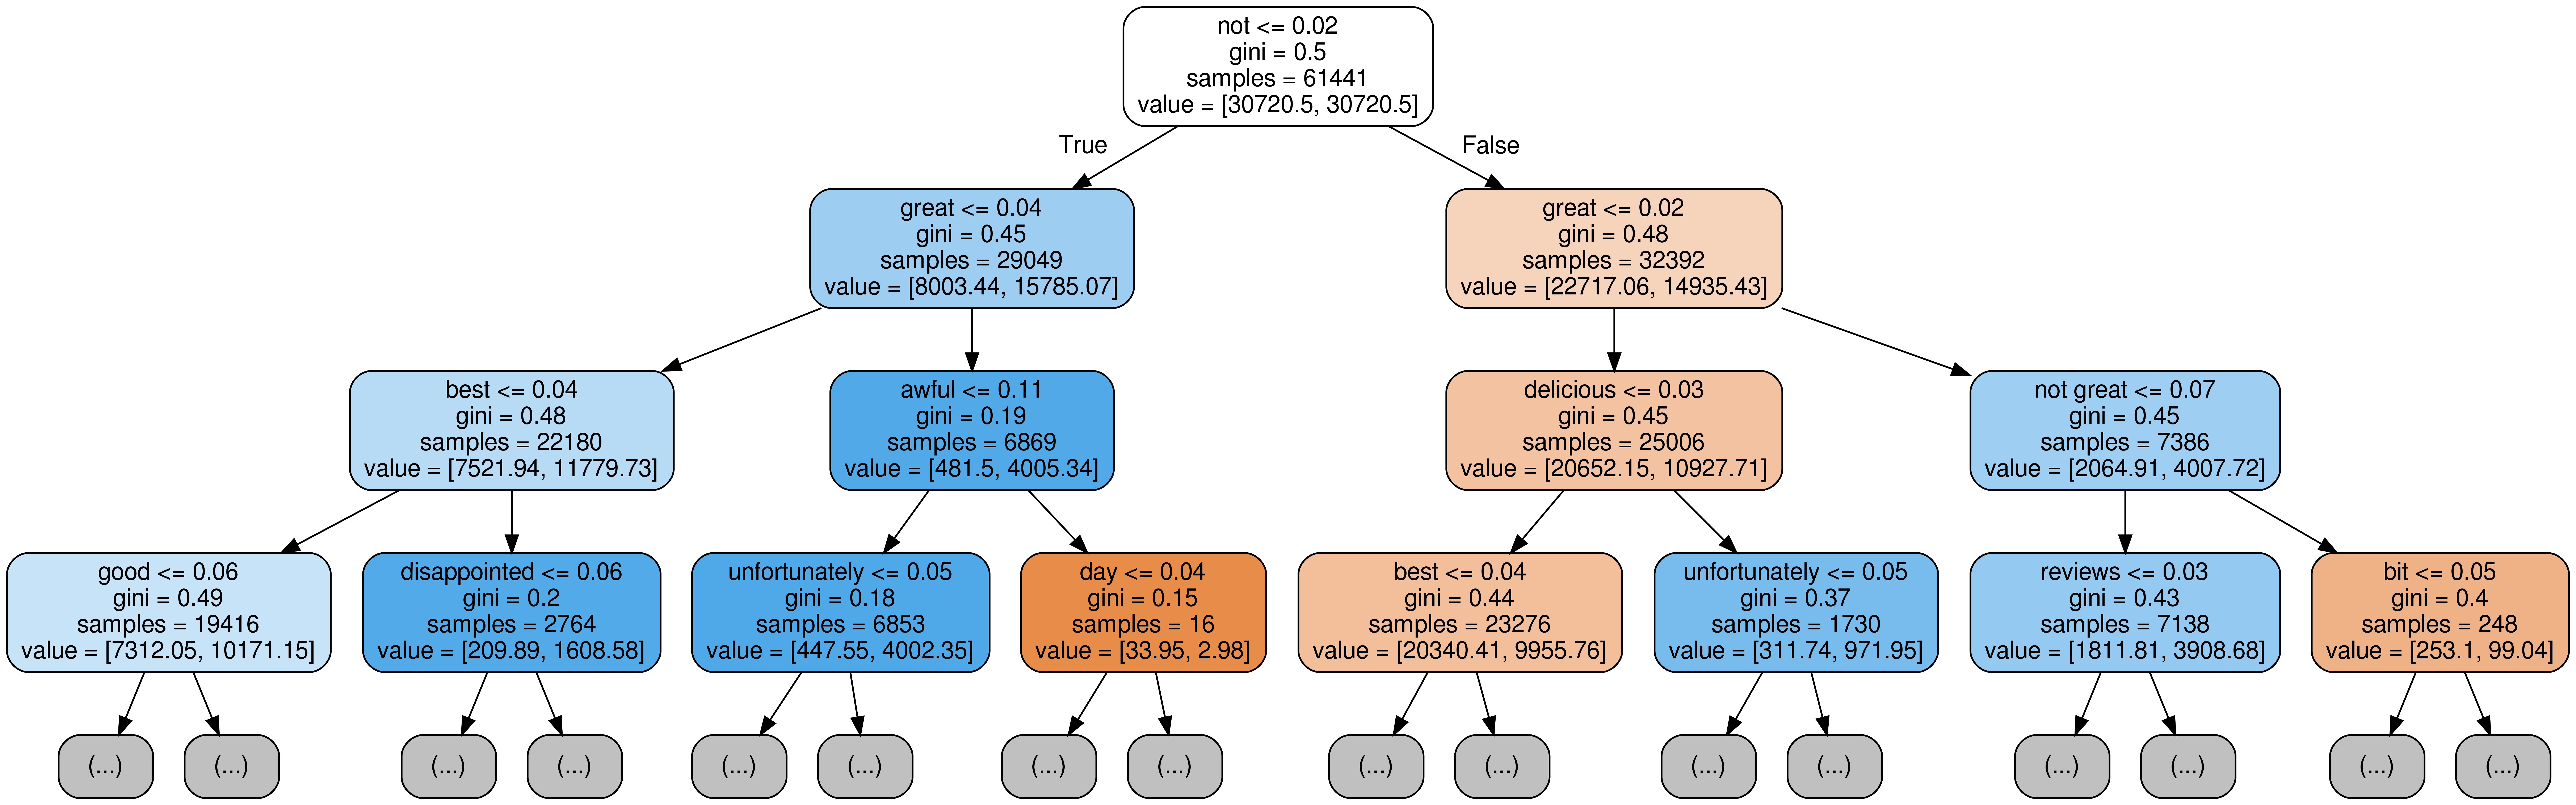

In [32]:
features_list = tf_idf_vect.get_feature_names()
# Export as dot file
export_graphviz(optimal_model, 
                out_file='tfidf.dot', 
                max_depth=3,
                rounded = True, 
                proportion = False, 
                precision = 2, 
                filled = True,
                special_characters=False,
                feature_names=features_list
               )

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tfidf.dot', '-o', 'tfidf.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tfidf.png')

### Feature Engineering

Till now we only consider Text review as feature, we are adding some extra feature like __review summary__ and __number of words__ in review and test our model improves efficiency or not.

We have considered on 50000 points due to memory issue.

(35000, 13) (15000, 13) (35000,) (15000,)

Confusion Matrix for Train data


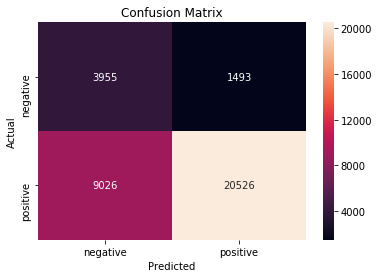


Confusion Matrix for Test data


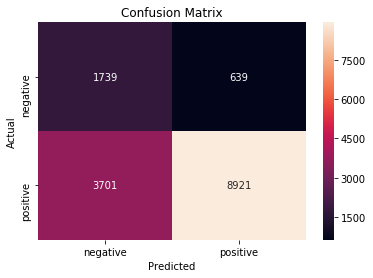

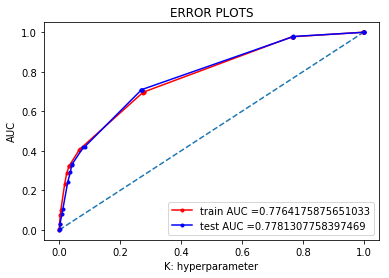


AUC (Train): 0.7764175875651033

AUC (Test): 0.7781307758397469

F1 SCORE (Train) : 0.7960287758624033

F1 SCORE (Test) : 0.8043458660174917

RECALL (Train): 0.6945722793719545

RECALL (Test): 0.7067818095389004

PRECISION  (Train) : 0.9321949225668741

PRECISION  (Test) : 0.9331589958158996


In [33]:
# https://sondosatwi.wordpress.com/2017/08/01/using-text-data-and-dataframemapper-in-python/

X = final[:50000]
y = final['Score'][:50000]

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

mapper = DataFrameMapper([
     ('preprocessed_reviews', TfidfVectorizer(ngram_range=(1,3), min_df=10)),
     ('preprocessed_summary', TfidfVectorizer(ngram_range=(1,3), min_df=10)),
     ('numbers_of_words', None),
 ])

train_features = mapper.fit_transform(X_train)
test_features = mapper.transform(x_test)

optimal_model = DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

# fitting the model
optimal_model.fit(train_features,y_train)

# predict the response
test_pred = optimal_model.predict(test_features)
train_pred = optimal_model.predict(train_features)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_model,train_features, y_train,test_features, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

## [4.4] Word2Vec

In [34]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(61441,) (26332,) (61441,) (26332,)


In [35]:
# Train your own Word2Vec model using your own text corpus

# Train data
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

# Test data
list_of_test_sentence = []
for sentance in x_test:
    list_of_test_sentence.append(sentance.split())

In [36]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    # train data
    w2v_model_tr=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    # train model on test data
    w2v_model_test = Word2Vec(list_of_test_sentence,min_count=5,size=50, workers=4)
    print(w2v_model_tr.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_tr.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.828421950340271), ('fantastic', 0.8274863958358765), ('good', 0.8206718564033508), ('excellent', 0.7979083061218262), ('terrific', 0.7951983213424683), ('wonderful', 0.7866204977035522), ('perfect', 0.7588126063346863), ('amazing', 0.716579794883728), ('fabulous', 0.7008994817733765), ('nice', 0.6937329173088074)]
[('greatest', 0.8112199306488037), ('best', 0.7294698357582092), ('tastiest', 0.6894100904464722), ('nastiest', 0.6444923877716064), ('closest', 0.6420760750770569), ('experienced', 0.6199789643287659), ('wins', 0.6151992678642273), ('disgusting', 0.6133275032043457), ('hottest', 0.597637951374054), ('ive', 0.5767107009887695)]


In [37]:
# train data operation
w2v_train_words = list(w2v_model_tr.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[0:50])

number of words that occured minimum 5 times  14910
sample words  ['aroma', 'flavor', 'seem', 'fine', 'weak', 'value', 'used', 'entire', 'bottle', 'quart', 'home', 'made', 'ice', 'cream', 'people', 'guessing', 'not', 'enough', 'licorice', 'spent', 'twice', 'price', 'really', 'concentrated', 'would', 'great', 'never', 'waste', 'money', 'item', 'like', 'shampoo', 'know', 'necessarily', 'hair', 'definitely', 'cleans', 'scalp', 'well', 'also', 'thickest', 'lather', 'ever', 'hellman', 'arguably', 'absolute', 'finest', 'mass', 'market', 'mayonnaise']


In [38]:
## test data operation
w2v_test_words = list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_test_words))
print("sample words ", w2v_test_words[0:50])

number of words that occured minimum 5 times  9806
sample words  ['used', 'use', 'cheaper', 'grocery', 'store', 'brands', 'two', 'cats', 'got', 'sick', 'no', 'idea', 'causing', 'changed', 'cat', 'food', 'anyway', 'love', 'healthy', 'made', 'good', 'cheese', 'corn', 'big', 'round', 'fresh', 'popcorn', 'evenly', 'seasoned', 'really', 'cheesy', 'flavor', 'not', 'salty', 'greasy', 'taste', 'sensational', 'ordering', 'disappointment', 'searching', 'awhile', 'find', 'flavored', 'water', 'artificial', 'sweetener', 'kind', 'saw', 'reviews', 'thought']


#### [4.4.1.1] Avg W2v

In [39]:
# average Word2Vec

# train data operation
exists = os.path.isfile(avg_w2v_trained_model_100000)
if exists:
    print("yes exist")
    final_w2v_train = load(avg_w2v_trained_model_100000)
else:
    print("not exist")
    # compute average word2vec for each review.
    final_w2v_train = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_train_words:
                vec = w2v_model_tr.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        final_w2v_train.append(sent_vec)
    print(len(final_w2v_train))
    print(len(final_w2v_train[0]))
    dump(final_w2v_train,avg_w2v_trained_model_100000)


# test data operation
exists = os.path.isfile(avg_w2v_test_model_100000)
if exists:
    print("yes exist")
    final_w2v_test = load(avg_w2v_test_model_100000)
else:
    print("not exist")
    final_w2v_test = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_test_sentence): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_test_words:
                vec = w2v_model_test.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        final_w2v_test.append(sent_vec)
    print(len(final_w2v_test))
    print(len(final_w2v_test[0]))
    dump(final_w2v_test,avg_w2v_test_model_100000)

yes exist
yes exist


### Hyper param Tuning using GridSearch

##### finding 'max depth' which have maximum AUC Score

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.6min finished


=======Training========
0.8110242873234847
{'max_depth': 7}
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')


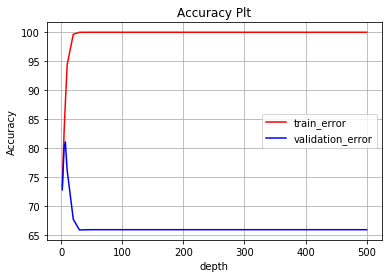

In [56]:
w2v_train = finding_best_depth_val(final_w2v_train,y_train,'gridsearch','depth')

# view the complete results (list of named tuples)
print("=======Training========")
print (w2v_train.best_score_)
print (w2v_train.best_params_)
print (w2v_train.best_estimator_)

plotAccuracyGraph(w2v_train, 'depth')
best_depth_size = w2v_train.best_params_.get("max_depth", "")

##### finding 'min sample' which have maximum AUC Score

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.1min finished


=======Training========
0.6956070191932676
{'min_samples_split': 18}
DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=18,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')


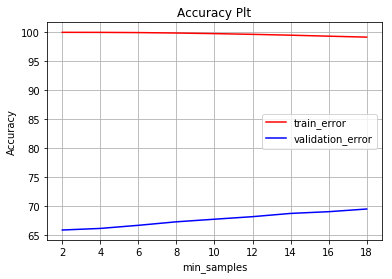

In [57]:
w2v_train = finding_best_depth_val(final_w2v_train,y_train,'gridsearch','min_samples')

# view the complete results (list of named tuples)
print("=======Training========")
print (w2v_train.best_score_)
print (w2v_train.best_params_)
print (w2v_train.best_estimator_)

plotAccuracyGraph(w2v_train, 'min_samples')
best_min_samples_split = bow_train.best_params_.get("min_samples_split","")

## Apply Decision Tree on W2V


Max Depth : 7

Min Sample Split : 7

Confusion Matrix for Train data


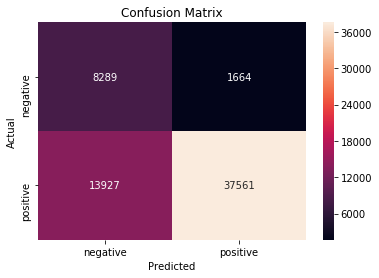


Confusion Matrix for Test data


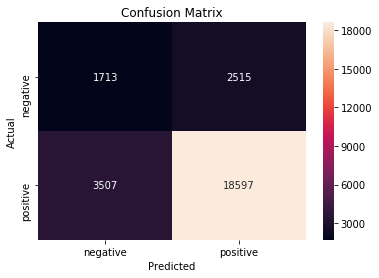

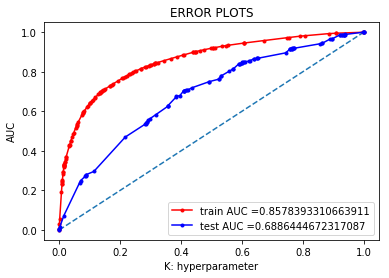


AUC (Train): 0.8578393310663911

AUC (Test): 0.6886444672317087

F1 SCORE (Train) : 0.8281282726841799

F1 SCORE (Test) : 0.860653461680859

RECALL (Train): 0.7295097886886265

RECALL (Test): 0.8413409337676439

PRECISION  (Train) : 0.9575780752071383

PRECISION  (Test) : 0.8808734369079196


In [50]:
optimal_model = DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

# fitting the model
optimal_model.fit(final_w2v_train, y_train)

# predict the response
test_pred = optimal_model.predict(final_w2v_test)
train_pred = optimal_model.predict(final_w2v_train)

print('\n'+color.RED+'Max Depth : '+color.END+color.BOLD+str(7)+color.END)
print('\n'+color.RED+'Min Sample Split : '+color.END+color.BOLD+str(7)+color.END)


# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_model,final_w2v_train, y_train,final_w2v_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)


## [4.4.1.2] TFIDF weighted W2v

In [45]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(61441,) (26332,) (61441,) (26332,)


In [46]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [47]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

# TF-IDF weighted Word2Vec

# Train data operation

# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(w2v_tf_idf_trained_model_100000)
if exists:
    print("yes exist")
    final_tfidf_w2v_tr = load(w2v_tf_idf_trained_model_100000)
else:   
    print("not exist")
    tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    final_tfidf_w2v_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_train_words and word in tfidf_feat:
                vec = w2v_model_tr.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        final_tfidf_w2v_tr.append(sent_vec)
        row += 1
    dump(final_tfidf_w2v_tr,w2v_tf_idf_trained_model_100000)
    
    
# Test data operation ============

# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(w2v_tf_idf_test_model_100000)
if exists:
    print("yes exist")
    final_tfidf_w2v_test = load(w2v_tf_idf_test_model_100000) 

else:   
    print("not exist")
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    final_tfidf_w2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_test_sentence): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_test_words and word in tfidf_feat:
                vec = w2v_model_test.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        final_tfidf_w2v_test.append(sent_vec)
        row += 1
    dump(final_tfidf_w2v_test,w2v_tf_idf_test_model_100000)
        

yes exist
yes exist


### Hyper param Tuning using GridSearch

##### finding 'max depth' which have maximum AUC Score

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.8min finished


=======Training========
0.7835481299915805
{'max_depth': 7}
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')


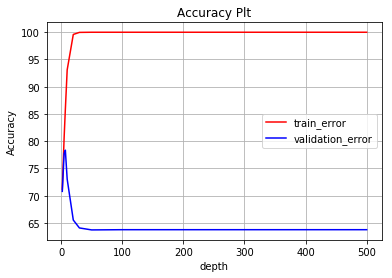

In [62]:
w2v_tfidf_train = finding_best_depth_val(final_tfidf_w2v_tr,y_train,'gridsearch','depth')

# view the complete results (list of named tuples)
print("=======Training========")
print (w2v_tfidf_train.best_score_)
print (w2v_tfidf_train.best_params_)
print (w2v_tfidf_train.best_estimator_)

plotAccuracyGraph(w2v_tfidf_train,'depth') 
best_depth_size = w2v_tfidf_train.best_params_.get("max_depth", "")

##### finding 'min sample' which have maximum AUC Score

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.9min finished


=======Training========
0.6788184876095207
{'min_samples_split': 18}
DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=18,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')


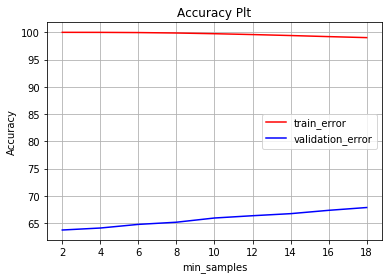

In [63]:
w2v_tfidf_train = finding_best_depth_val(final_tfidf_w2v_tr,y_train,'gridsearch','min_samples')
# view the complete results (list of named tuples)
print("=======Training========")
print (w2v_tfidf_train.best_score_)
print (w2v_tfidf_train.best_params_)
print (w2v_tfidf_train.best_estimator_)

plotAccuracyGraph(w2v_tfidf_train,'min_samples') 
best_min_samples_split = w2v_tfidf_train.best_params_.get("min_samples_split","")

## Decision Tree on TFIDF - W2V 


Max Depth : 7

Min Sample Split : 7

Confusion Matrix for Train data


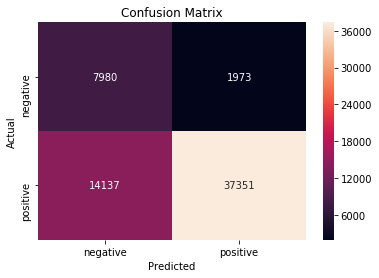


Confusion Matrix for Test data


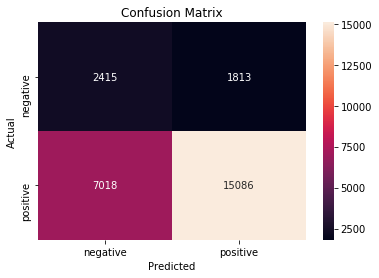

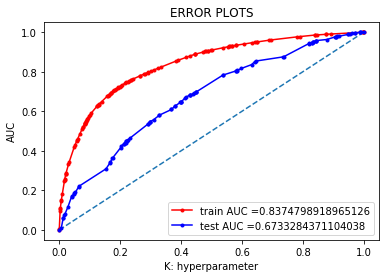


AUC (Train): 0.8374798918965126

AUC (Test): 0.6733284371104038

F1 SCORE (Train) : 0.8226005373739154

F1 SCORE (Test) : 0.7735815193703048

RECALL (Train): 0.7254311684275948

RECALL (Test): 0.6825009048136084

PRECISION  (Train) : 0.9498270776116366

PRECISION  (Test) : 0.8927155452985384


In [53]:
optimal_model =DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

# fitting the model
optimal_model.fit(final_tfidf_w2v_tr, y_train)

# predict the response
test_pred = optimal_model.predict(final_tfidf_w2v_test)
train_pred = optimal_model.predict(final_tfidf_w2v_tr)

print('\n'+color.RED+'Max Depth : '+color.END+color.BOLD+str(7)+color.END)
print('\n'+color.RED+'Min Sample Split : '+color.END+color.BOLD+str(7)+color.END)


# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_model,final_tfidf_w2v_tr, y_train,final_tfidf_w2v_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

# [6] Conclusions

In [57]:
import pandas as pd
from prettytable import PrettyTable

print(color.BOLD+'\t\t\t\t Decision Tree  '+color.END)
print('\n')

print(color.BOLD+'For BOW and TFIDF, We have considered 100k points'+color.END)
print(color.BOLD+'For BOW- Additional Feature and TFIDF- Additional Feature, We have considered 50k points'+color.END)


x = PrettyTable()
x.field_names =  ['Metric','BOW','BOW-Additional Feature', 'TFIDF', 'TFIDF- Additional Features','W2V','TFIDF-W2V']

x.add_row(["Max Depth ", 5,5,5,5,7,7])
x.add_row(["Min Sample Split ", 5,5,7,7,7,7])


x.add_row(["AUC Train ", 0.74127,0.77528,0.74331,0.77641,0.85783,0.83747])
x.add_row(["AUC Test ", 0.73074,0.78010,0.72996,0.72813,0.68864,0.67332])

x.add_row(["F1 SCORE Train ", 0.80405,0.79628,0.80986,0.79602,0.82812,0.82260])
x.add_row(["F1 SCORE Test ", 0.80184,0.80451,0.80930,0.80434,0.86065,0.77358])

x.add_row(["RECALL Train ",0.71570,0.69369,0.72547,0.69457,0.72950,0.72543])
x.add_row(["RECALL Test ", 0.71240,0.70575,0.72195,0.70678,0.84134,0.68250])
93449
x.add_row(["PRECISION Train ", 0.9173,0.93449,0.91648,0.93219,0.95757,0.94982])
x.add_row(["PRECISION Test ",0.91696,0.93541,0.91554,0.93315,0.88082,0.89271])


print('\n')
print(x)


				 Decision Tree  


For BOW and TFIDF, We have considered 100k points
For BOW- Additional Feature and TFIDF- Additional Feature, We have considered 50k points


+-------------------+---------+------------------------+---------+----------------------------+---------+-----------+
|       Metric      |   BOW   | BOW-Additional Feature |  TFIDF  | TFIDF- Additional Features |   W2V   | TFIDF-W2V |
+-------------------+---------+------------------------+---------+----------------------------+---------+-----------+
|     Max Depth     |    5    |           5            |    5    |             5              |    7    |     7     |
| Min Sample Split  |    5    |           5            |    7    |             7              |    7    |     7     |
|     AUC Train     | 0.74127 |        0.77528         | 0.74331 |          0.77641           | 0.85783 |  0.83747  |
|     AUC Test      | 0.73074 |         0.7801         | 0.72996 |          0.72813           | 0.68864 |  0.67332  |
|  F1 SCOR